<a href="https://colab.research.google.com/github/owosade/Explainable-AI---Final/blob/main/Final_Project_Kidney_Stone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#Importing fastai
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [28]:
#Importing all objects and functions from the fastai module
from fastbook import *
from fastai.vision.all import *


#creating an object named "Path"
path = Path('/content/gdrive/MyDrive/Dataset')

#obtaining the list of images from the object created
train_filenames = get_image_files(path/"Train")

In [29]:
#setting up a data pipeline for image classification

#augmentations include random resized cropping with a minimum scale of 0.75, rotation, and zooming.
augumentations = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]

#Specifying the datablock type
data_block = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   #random splitter for data. 80% for training and 20% for validation
                   splitter=RandomSplitter(valid_pct=0.2, seed=23),
                   get_y=parent_label,
                   #resizing image to 512 pixels
                   item_tfms=Resize(512, method="squish"),

                   #applying data augumentation technique defined by funtion "augumentations"
                   batch_tfms=augumentations,
                   )
#loading data for training
load_data = data_block.dataloaders(train_filenames)

In [30]:
# print number of classes and length of train and valid datasets. Showing the 2 classes/ folders
load_data.c, len(load_data.train_ds), len(load_data.valid_ds), load_data.vocab



(2, 1163, 290, ['Kidney_stone', 'Normal'])

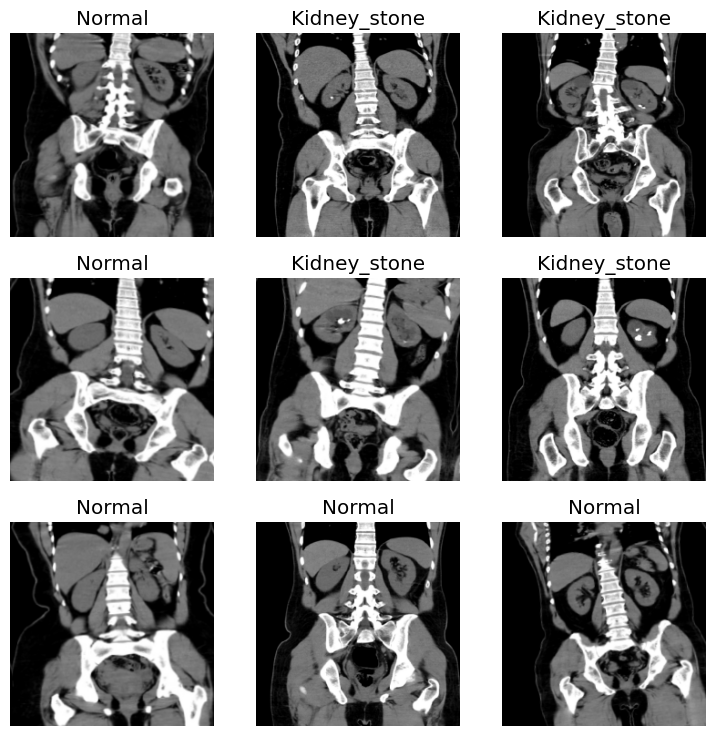

In [31]:
#Showing sample images in the folder
load_data.show_batch()

In [32]:
#  creating the body and head of the neural network using the create_body and create_head function
#  Using nn.Sequential container is used to sequentially concatenate the body and head components

model = nn.Sequential(create_body(xresnet50(), pretrained=False),create_head(nf=2048, n_out=2))


#Obtaining the train loss and valid loss of the model
learn = cnn_learner(load_data, resnet34, metrics=accuracy).to_fp16()
learn.fit_one_cycle(40, 1e-2)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,1.079932,1.332107,0.596552,08:45
1,0.958233,0.921036,0.634483,08:16
2,0.823520,0.632954,0.765517,08:11
3,0.713319,0.655904,0.775862,08:15
4,0.580281,0.441740,0.831034,08:26
5,0.474922,0.313011,0.893103,08:12
6,0.377427,0.293100,0.913793,08:13
7,0.313920,0.354904,0.900000,08:10
8,0.263650,0.446108,0.900000,08:18
9,0.235481,0.290673,0.900000,08:01


epoch,train_loss,valid_loss,accuracy,time
0,1.079932,1.332107,0.596552,08:45
1,0.958233,0.921036,0.634483,08:16
2,0.823520,0.632954,0.765517,08:11
3,0.713319,0.655904,0.775862,08:15
4,0.580281,0.441740,0.831034,08:26
5,0.474922,0.313011,0.893103,08:12
6,0.377427,0.293100,0.913793,08:13
7,0.313920,0.354904,0.900000,08:10
8,0.263650,0.446108,0.900000,08:18
9,0.235481,0.290673,0.900000,08:01


In [33]:
#Saving the state of the model
learn.save(path/'Final_project2')

Path('/content/gdrive/MyDrive/Dataset/Final_project2.pth')

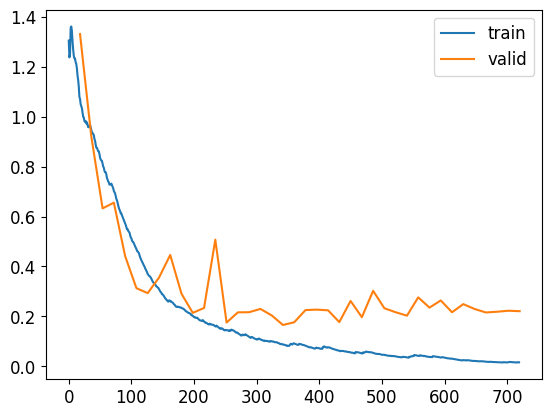

In [34]:
#ploting model's training progress to observe the training and validation losses over time
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [35]:
#test_items = get_image_files(path/"Test")
files= get_image_files(path)

In [36]:
# Evaluating the performance

#data modification
augumentations = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]

#data block creation
data_block = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=GrandparentSplitter(train_name='Train', valid_name='Test'),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augumentations,
                   )

load_data_test = data_block.dataloaders(files)


In [37]:
import torch
model = nn.Sequential(create_body(xresnet50(), pretrained=False),create_head(nf=2048, n_out=2))

#Loading the saved model
learn = cnn_learner(load_data, resnet34, metrics=accuracy).to_fp16()
learn = learn.load('/content/gdrive/MyDrive/Dataset/Final_project2')

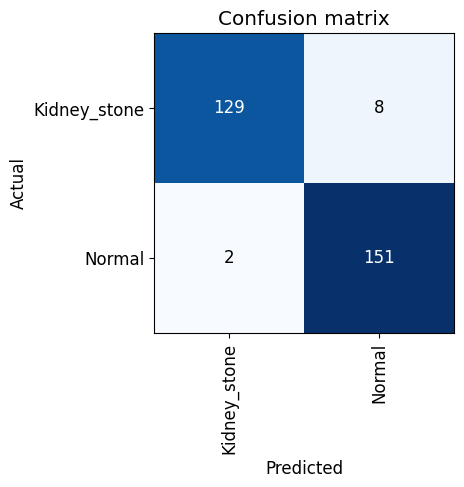

In [38]:
#creating the confusion matrix to get the accuracy
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [39]:
interp.print_classification_report()

              precision    recall  f1-score   support

Kidney_stone       0.98      0.94      0.96       137
      Normal       0.95      0.99      0.97       153

    accuracy                           0.97       290
   macro avg       0.97      0.96      0.97       290
weighted avg       0.97      0.97      0.97       290

